This notebook contains code to create plots and performance results for the trained RL agents. You have to download data from wandb first, using `wandb_to_csv.ipynb`.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import os

In [3]:
data = pd.read_csv("downloaded_runs.csv")

In [4]:
data

,env_name,repl_mode,total_timesteps,name,global_step,rollout/ep_len_mean,rollout/ep_rew_mean
0,MiniWorld-WallGap-v0,sfa,2000000.0,decent-night-122,384.0,300.000000,0.000000
1,MiniWorld-WallGap-v0,sfa,2000000.0,decent-night-122,512.0,300.000000,0.000000
2,MiniWorld-WallGap-v0,sfa,2000000.0,decent-night-122,640.0,300.000000,0.000000
3,MiniWorld-WallGap-v0,sfa,2000000.0,decent-night-122,768.0,300.000000,0.000000
4,MiniWorld-WallGap-v0,sfa,2000000.0,decent-night-122,896.0,300.000000,0.000000
...,...,...,...,...,...,...,...
1093318,MiniWorld-StarMazeArm-v0,pca,1000000.0,leafy-moon-31,999552.0,769.900024,0.553347
1093319,MiniWorld-StarMazeArm-v0,pca,1000000.0,leafy-moon-31,999680.0,769.900024,0.553347
1093320,MiniWorld-StarMazeArm-v0,pca,1000000.0,leafy-moon-31,999808.0,769.900024,0.553347
1093321,MiniWorld-StarMazeArm-v0,pca,1000000.0,leafy-moon-31,999936.0,769.900024,0.553347


In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less than `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError(
            f"window_size is {window_size} but must be a positive odd number")
    if window_size < order + 2:
        raise TypeError(
            f"window_size {window_size} is too small for polynomials of order {order}"
        )
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range]
                for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

In [6]:
def smooth(arr, smoothing):
    # smoothing must be an odd number, 0 means no smoothing
    if smoothing > 0:
        return savitzky_golay(arr,
                              smoothing,
                              3 if smoothing >= 5 else 1,
                              deriv=0,
                              rate=1)
    else:
        return arr

In [7]:
# numpy default colors:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]
# custom colors:
colors = ['#004d40', '#dca500', '#1e88e5', '#d81b60']
fs = 20
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

In [8]:
list(data["env_name"].unique())

['MiniWorld-WallGap-v0',
 'MiniWorld-FourColoredRooms-v0',
 'MiniWorld-StarMazeRandom-v0',
 'MiniWorld-StarMazeArm-v0']

In [9]:
legend_dict = OrderedDict((("sfa", "SFA"),
                           ("cnn", "NatureCNN"),
                           ("cnn_comp", "CustomCNN"),
                           ("pca", "PCA"),
                           ("random", "Random"),
                           ("optimal", "Optimal")))

In [10]:
env_dict = {'MiniWorld-StarMazeArm-v0': 'StarMazeArm',
             'MiniWorld-StarMazeRandom-v0': 'StarMazeRandom',
             'MiniWorld-WallGap-v0': 'WallGap',
             'MiniWorld-FourColoredRooms-v0': 'FourColoredRooms'}

In [11]:
random_agent = {'MiniWorld-StarMazeArm-v0': 1133.67,
             'MiniWorld-StarMazeRandom-v0': 1072.97,
             'MiniWorld-WallGap-v0': 300.0,
             'MiniWorld-FourColoredRooms-v0': 231.03}
optimal = {'MiniWorld-StarMazeArm-v0': 35.5,
             'MiniWorld-StarMazeRandom-v0': 16.4,
             'MiniWorld-WallGap-v0': 75.6,
             'MiniWorld-FourColoredRooms-v0': 53}

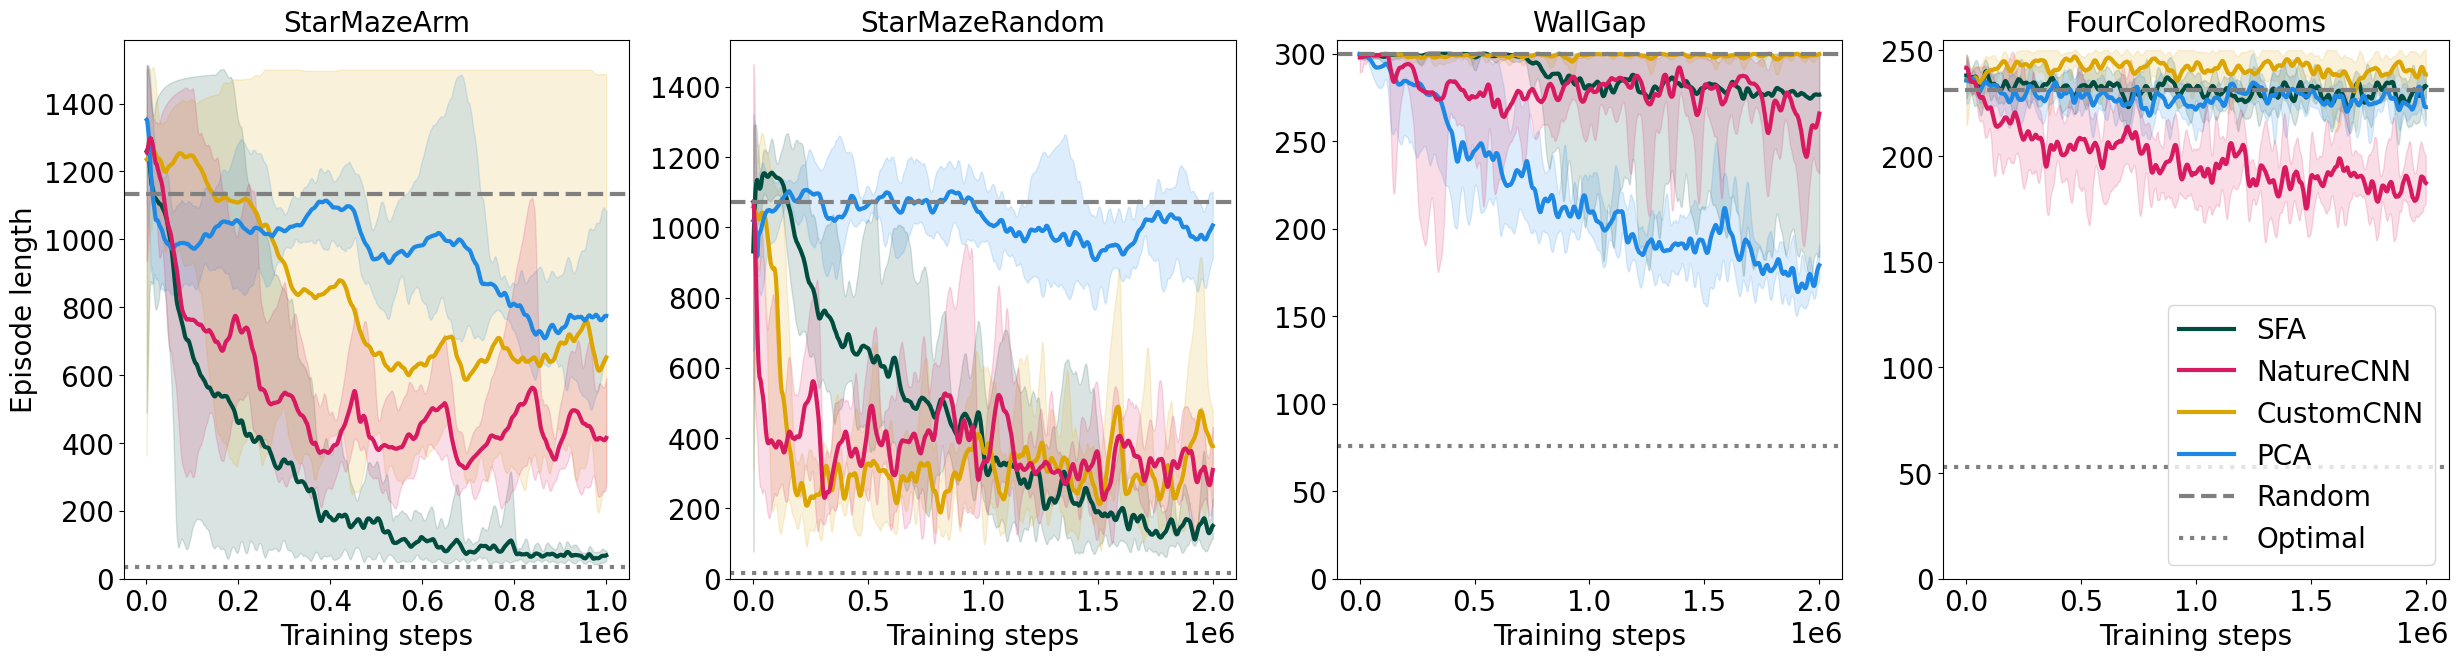

In [12]:
fig, axes = plt.subplots(1,4, figsize=(30,7))

# env_names = list(data["env_name"].unique())
# Sort this list manually:
env_names = ['MiniWorld-StarMazeArm-v0',
             'MiniWorld-StarMazeRandom-v0',
             'MiniWorld-WallGap-v0',
             'MiniWorld-FourColoredRooms-v0',]
for i, env in enumerate(env_names):
    ax = axes[i]#[i//2][i%2]

    env_data = data[data["env_name"]==env]
    repl_modes = list(data["repl_mode"].unique())    
    for j,  mode in enumerate(repl_modes):

        mode_data = env_data[env_data["repl_mode"]==mode]
        run_names = list(data[(data["env_name"]==env) & (data["repl_mode"]==mode)]["name"].unique())

        ep_length_list = []
        global_steps_list = []
        for run in run_names:
            run_data = mode_data[mode_data["name"]==run]
            ep_length_list.append(run_data["rollout/ep_len_mean"].to_numpy())
            global_steps_list.append(run_data["global_step"].to_numpy())

        # Make all runs equally long
        min_list_length = np.min([len(el) for el in ep_length_list])
        truncated_ep_length_list = []
        truncated_global_steps_list = []
        for el1, el2 in zip(ep_length_list, global_steps_list):
            truncated_ep_length_list.append(el1[len(el1)-min_list_length:])
            truncated_global_steps_list.append(el2[len(el2)-min_list_length:])

        ep_lengths = np.array(truncated_ep_length_list)
        global_steps = np.array(truncated_global_steps_list)
        
        # Define amount of smoothing with sval:
        sval = int(np.max(global_steps)*1.5e-4) + 1

        ax.plot(global_steps[0], smooth(np.mean(ep_lengths, axis=0), sval), c=colors[j], linewidth=3, label=legend_dict[mode])
        maxs = smooth(np.max(ep_lengths, axis=0), sval)
        mins = smooth(np.min(ep_lengths, axis=0), sval)
        ax.fill_between(global_steps[0], maxs, mins, color=colors[j], alpha=0.15)

    ax.set_title(f"{env_dict[env]}")
    ax.set_ylim(0, None)
    #ax.set_xlim(0, np.max(global_steps))
    #if i//2 == 1:
    ax.set_xlabel("Training steps")
    # if i%2 == 0:
    if i==0:
        ax.set_ylabel("Episode length")
    ax.axhline(random_agent[env], linestyle="--", linewidth=3, c="grey", label="Random")
    ax.axhline(optimal[env], linestyle=":", linewidth=3, c="grey", label="Optimal")

ax = axes[3]#[1][0]
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles),
                              key=lambda item: list(legend_dict.values()).index(item[0])))
ax.legend(handles, labels, loc="lower right")
plt.show()
plt.close()

In [16]:
os.makedirs('../images/', exist_ok=True)
fig.savefig('../images/results_agents.svg', bbox_inches='tight', format = 'svg', dpi=300)
fig.savefig('../images/results_agents.png', bbox_inches='tight', format = 'png', dpi=300)

In [31]:
# env_names = list(data["env_name"].unique())
# Sort this list manually:
env_names = ['MiniWorld-StarMazeArm-v0',
             'MiniWorld-StarMazeRandom-v0',
             'MiniWorld-WallGap-v0',
             'MiniWorld-FourColoredRooms-v0',]
for i, env in enumerate(env_names):
    print(env)

    env_data = data[data["env_name"]==env]
    repl_modes = list(data["repl_mode"].unique())    
    for j,  mode in enumerate(repl_modes):
        print(mode)

        mode_data = env_data[env_data["repl_mode"]==mode]
        run_names = list(data[(data["env_name"]==env) & (data["repl_mode"]==mode)]["name"].unique())

        ep_length_list = []
        global_steps_list = []
        for run in run_names:
            run_data = mode_data[mode_data["name"]==run]
            ep_length_list.append(run_data["rollout/ep_len_mean"].to_numpy())
            global_steps_list.append(run_data["global_step"].to_numpy())

        # Make all runs equally long
        min_list_length = np.min([len(el) for el in ep_length_list])
        truncated_ep_length_list = []
        truncated_global_steps_list = []
        for el1, el2 in zip(ep_length_list, global_steps_list):
            truncated_ep_length_list.append(el1[len(el1)-min_list_length:])
            truncated_global_steps_list.append(el2[len(el2)-min_list_length:])

        ep_lengths = np.array(truncated_ep_length_list)
        global_steps = np.array(truncated_global_steps_list)
        
        avg_end = np.mean(ep_lengths[:,-1])
        min_end = np.min(ep_lengths[:,-1])
        max_end = np.max(ep_lengths[:,-1])
        
        print(f"Mean: {avg_end:.2f}, max diff: {np.round(np.max(np.abs([avg_end-min_end, avg_end-max_end])))}, (min, max): ({min_end:.2f}, {max_end:.2f})")
        
    print("\n\n")

MiniWorld-StarMazeArm-v0
sfa
Mean: 68.73, max diff: 16.0, (min, max): (52.42, 81.02)
cnn_comp
Mean: 652.08, max diff: 835.0, (min, max): (287.92, 1487.36)
pca
Mean: 773.04, max diff: 296.0, (min, max): (621.22, 1069.09)
cnn
Mean: 415.26, max diff: 176.0, (min, max): (269.99, 591.50)



MiniWorld-StarMazeRandom-v0
sfa
Mean: 147.20, max diff: 80.0, (min, max): (91.97, 227.34)
cnn_comp
Mean: 364.05, max diff: 170.0, (min, max): (193.64, 442.80)
pca
Mean: 1005.31, max diff: 94.0, (min, max): (911.33, 1098.79)
cnn
Mean: 308.92, max diff: 121.0, (min, max): (225.50, 430.24)



MiniWorld-WallGap-v0
sfa
Mean: 276.51, max diff: 93.0, (min, max): (183.67, 300.00)
cnn_comp
Mean: 299.78, max diff: 1.0, (min, max): (298.92, 300.00)
pca
Mean: 178.77, max diff: 12.0, (min, max): (167.56, 190.61)
cnn
Mean: 265.79, max diff: 34.0, (min, max): (232.75, 300.00)



MiniWorld-FourColoredRooms-v0
sfa
Mean: 231.68, max diff: 8.0, (min, max): (225.05, 239.19)
cnn_comp
Mean: 237.24, max diff: 27.0, (min, max):